In [21]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

### Originals image path

In [3]:
path = Path('database/originals')

### HSV, YCrCb and LAB paths 

In [167]:
HSV_path = 'tests/HSV'
Path(HSV_path).mkdir(parents=True, exist_ok=True)

YCrCb_path = 'tests/YCrCb'
Path(YCrCb_path).mkdir(parents=True, exist_ok=True)

LAB_path = 'tests/LAB'
Path(LAB_path).mkdir(parents=True, exist_ok=True)

### Convert BGR images to HSV/YCrCb/LAB 

In [168]:
def other_colors(file, HSV_path, YCrCb_path, LAB_path): 
    image = cv2.imread(file.__str__())
    
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    cv2.imwrite(HSV_path + '/' + file.name, hsv)
    cv2.imwrite(YCrCb_path + '/' + file.name, ycrcb)
    cv2.imwrite(LAB_path + '/' + file.name, lab)
    
    name = file.name.split('.')[0]
    
    h, s, v = cv2.split(hsv)
    cv2.imwrite(HSV_path + '/' + name + '_h.jpg', h)
    cv2.imwrite(HSV_path + '/' + name + '_s.jpg', s)
    cv2.imwrite(HSV_path + '/' + name + '_v.jpg', v)

    y, cr, cb = cv2.split(ycrcb)
    cv2.imwrite(YCrCb_path + '/' + name + '_y.jpg', y)
    cv2.imwrite(YCrCb_path + '/' + name + '_cr.jpg', cr)
    cv2.imwrite(YCrCb_path + '/' + name + '_cb.jpg', cb)

    l, a, b = cv2.split(ycrcb)
    cv2.imwrite(LAB_path + '/' + name + '_l.jpg', l)
    cv2.imwrite(LAB_path + '/' + name + '_a.jpg', a)
    cv2.imwrite(LAB_path + '/' + name + '_b.jpg', b)


In [169]:
files = [file for file in path.iterdir() if file.is_file()]

for file in files:
    other_colors(file, HSV_path, YCrCb_path, LAB_path)

### Get LAB images

In [170]:
LAB_thresh_path = 'tests/LAB_thresh'
Path(LAB_thresh_path).mkdir(parents=True, exist_ok=True)

In [7]:
path_lab = Path(LAB_path)

In [8]:
files_lab = [file for file in path_lab.iterdir() if file.is_file() and '_' not in file.name]

### Colors range

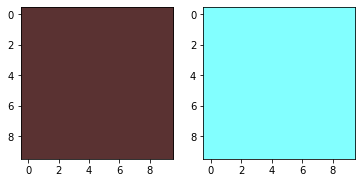

In [196]:
lower = np.array([90,50,50])
upper = np.array([130,255,255])

lo_square = np.full((10, 10, 3), lower, dtype=np.uint8) / 255.0
do_square = np.full((10, 10, 3), upper, dtype=np.uint8) / 255.0

plt.subplot(1, 2, 1)
plt.imshow(lo_square)
plt.subplot(1, 2, 2)
plt.imshow(do_square)
plt.show()

### With the LAB image, remove regions beyond the color (using the previous color range)

In [210]:
import math


def euclideanDistance(instance1, instance2, length):
    distance = 0
    
    for x in range(length):
        distance += pow((instance1[x] - instance2[x]), 2)
    
    return math.sqrt(distance)

In [240]:
import operator 


def getNeighbors(trainingSet, testInstance, k, maxDist):
    distances = []
    length = len(testInstance)

    for x in range(len(trainingSet)):
        dist = euclideanDistance(testInstance, trainingSet[x], length)
        distances.append((trainingSet[x], dist))
  
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    
    for x in range(k):
        if len(distances) > x:
            if distances[x][1] < maxDist+1: 
                neighbors.append(distances[x][0])
    
    return neighbors

In [245]:
def remove_isolated_regions(image, points, k=5, maxDist=300):
    cp = image.copy()
    coord = [p[0:2] for p in points]
    
    for i, c in enumerate(coord):
        neighbors = getNeighbors(coord, c, k, maxDist)
        neighbors = len(neighbors)
        if (neighbors >= k):
            cv2.rectangle(cp, (points[i][0],points[i][1]),
                          (points[i][0]+points[i][2],
                           points[i][1]+points[i][3]),(255,0,0),2)
    
    return cp

In [247]:
for file in files_lab:
    image = cv2.imread(file.__str__())
    
    mask = cv2.inRange(image, lower, upper)
    
    result = cv2.bitwise_and(image, image, mask=mask)    
    result_gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
    
    _,thresh = cv2.threshold(result_gray,0,255,cv2.THRESH_BINARY)
    cv2.imwrite(LAB_thresh_path + '/' + file.name, thresh)
    
    cnts,_ = cv2.findContours(thresh, 1, 2)
    
    points = []
    cp = image.copy()
    
    for cnt in cnts:
        area = cv2.contourArea(cnt)
        
        if area > 20:
            x,y,w,h = cv2.boundingRect(cnt)
            points.append([x, y, w, h])
    
    cp = remove_isolated_regions(image, points)    
            
    cv2.imwrite(LAB_thresh_path + '/cp_' + file.name, cp)